<a href="https://colab.research.google.com/github/dine1717/EVA6/blob/Session5/Step_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       #transforms.RandomErasing(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


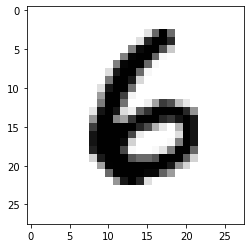

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

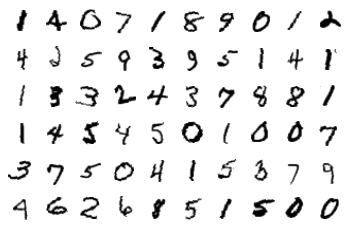

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

## Target
1. Less than 7000 parameters
2. Less than 15 epochs
3. Test with Cyclic LR
4. Add small dropout of 5%

## Results
1. Number of Parameters = 6202 + 140 non trainable BN params
2. Best Train Accuracy = 98.97
3. Best Test Accuracy = 99.45

## Analysis
1. We pushed the model to achieve target with approx 6000 Parameters
2. Drop in accuracy was predicted because of making the training more difficult. But still we met the target.

In [7]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Convolution Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_side = 28, output_size = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 28, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 10, RF = 14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8, RF = 18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6, RF = 22

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 4, RF = 26

        # OUTPUT BLOCK
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 26

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
           Dropout-3           [-1, 10, 28, 28]               0
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
           Dropout-7           [-1, 10, 28, 28]               0
              ReLU-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
           Dropout-3           [-1, 10, 28, 28]               0
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
           Dropout-7           [-1, 10, 28, 28]               0
              ReLU-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_epoch_end = []

def train(model, device, train_loader, optimizer, epoch,scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    scheduler.step()
  train_epoch_end.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=15)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler)
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    #scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.09593421220779419 Batch_id=468 Accuracy=77.39: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1290: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch: 0 LR: [0.015240079703465942]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0928, Accuracy: 9717/10000 (97.17%)

EPOCH: 1


Loss=0.16700364649295807 Batch_id=468 Accuracy=96.89: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]

Epoch: 1 LR: [0.04369617749135263]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0889, Accuracy: 9727/10000 (97.27%)

EPOCH: 2


Loss=0.03717203065752983 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]

Epoch: 2 LR: [0.07604125973093226]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9851/10000 (98.51%)

EPOCH: 3


Loss=0.010624379850924015 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]

Epoch: 3 LR: [0.09712693882270339]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.12689918279647827 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s]

Epoch: 4 LR: [0.09943677941594807]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9886/10000 (98.86%)

EPOCH: 5


Loss=0.10775119066238403 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]

Epoch: 5 LR: [0.09503461424944769]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.09986478090286255 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:14<00:00, 31.34it/s]

Epoch: 6 LR: [0.0866309437466121]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.1006753072142601 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:15<00:00, 31.16it/s]

Epoch: 7 LR: [0.0749724709105188]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.008269007317721844 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]

Epoch: 8 LR: [0.061095102215020056]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.05668012425303459 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]


Epoch: 9 LR: [0.046231902768540376]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.07561907172203064 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:14<00:00, 31.28it/s]

Epoch: 10 LR: [0.031703533067975895]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.034509677439928055 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]

Epoch: 11 LR: [0.018800902517922092]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.055131133645772934 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]

Epoch: 12 LR: [0.008670466465012771]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.07956694811582565 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]

Epoch: 13 LR: [0.0022123586092353013]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9948/10000 (99.48%)

EPOCH: 14


Loss=0.02109983004629612 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s]

Epoch: 14 LR: [4.101745150496986e-07]



Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)



Text(0.5, 1.0, 'Test Accuracy')

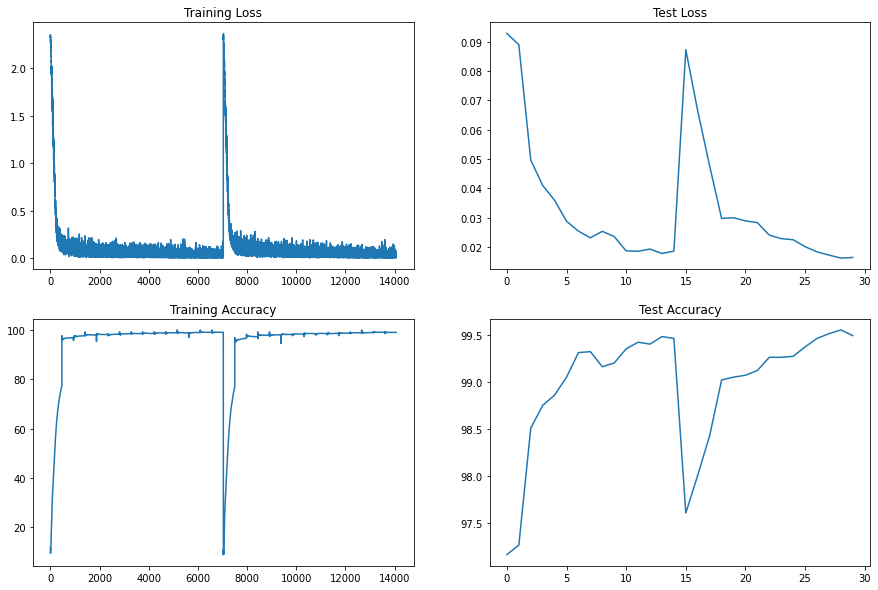

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

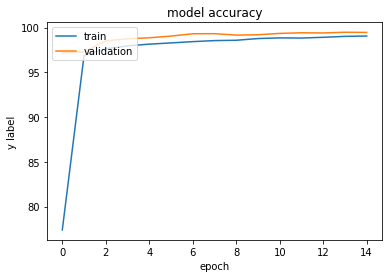

99.05666666666667
99.48


In [12]:
plt.plot(train_epoch_end)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('y label')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print(max(train_epoch_end[:15]))
print(max(test_acc[:15]))

In [13]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=15)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler)
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    #scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.07048527151346207 Batch_id=468 Accuracy=76.89: 100%|██████████| 469/469 [00:14<00:00, 31.85it/s]

Epoch: 0 LR: [0.015240079703465942]



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1290: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0872, Accuracy: 9761/10000 (97.61%)

EPOCH: 1


Loss=0.1311129778623581 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]

Epoch: 1 LR: [0.04369617749135263]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9801/10000 (98.01%)

EPOCH: 2


Loss=0.10414311289787292 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]

Epoch: 2 LR: [0.07604125973093226]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9843/10000 (98.43%)

EPOCH: 3


Loss=0.06269307434558868 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]

Epoch: 3 LR: [0.09712693882270339]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.045244213193655014 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:14<00:00, 32.04it/s]

Epoch: 4 LR: [0.09943677941594807]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.0484548918902874 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]


Epoch: 5 LR: [0.09503461424944769]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.03689543157815933 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]

Epoch: 6 LR: [0.0866309437466121]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.027614576742053032 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s]

Epoch: 7 LR: [0.0749724709105188]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.04659063741564751 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]

Epoch: 8 LR: [0.061095102215020056]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.06841491162776947 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]

Epoch: 9 LR: [0.046231902768540376]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.028516991063952446 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]

Epoch: 10 LR: [0.031703533067975895]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.035678379237651825 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]

Epoch: 11 LR: [0.018800902517922092]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


Loss=0.04060344025492668 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]

Epoch: 12 LR: [0.008670466465012771]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9951/10000 (99.51%)

EPOCH: 13


Loss=0.0041638887487351894 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]

Epoch: 13 LR: [0.0022123586092353013]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9955/10000 (99.55%)

EPOCH: 14


Loss=0.002318849554285407 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]

Epoch: 14 LR: [4.101745150496986e-07]



Test set: Average loss: 0.0164, Accuracy: 9949/10000 (99.49%)

